In [1]:
import numpy as np
import os
from qcodes import Station
from qcodes.dataset.plotting import plot_dataset
from qcodes.utils.validators import Numbers, Arrays
from qcodes.instrument.base import Instrument
from qcodes.logger.logger import start_all_logging
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment
import matplotlib.pyplot as plt

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lucam\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lucam\.qcodes\logs\200505-40992-qcodes.log


In [2]:
# Sempre importante iniciar o logging
start_all_logging()

Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lucam\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lucam\.qcodes\logs\200505-40992-qcodes.log


In [3]:

# Classe que faz o papel do PSG no lab. Aqui ela basicamente guarda os valores de freq e amplitude    
class DummySignalGenerator(Instrument):
    
    def __init__(self, name,ifreq=5,iamp=-5, **kwargs):

        super().__init__(name, **kwargs)
        
        self.add_parameter('freq',
                           initial_value=ifreq,
                           unit='Hz',
                           label='frequency',
                           vals=Numbers(0,2000),
                           get_cmd=None,
                           set_cmd=None)
        
        self.add_parameter('amp',
                           initial_value=iamp,
                           unit='mV',
                           label='amplitude',
                           vals=Numbers(-5000,5000),
                           get_cmd=None,
                           set_cmd=None)

# Exemplo de como crirar um instrumento
PSG = DummySignalGenerator("SignalGenerator")



In [4]:
# Essa classe representa um parâmetro de conjuto de pontos. Será usado pelo osciloscópio para representar o eixo do tempo.
class GeneratedSetPoints(Parameter):
    """
    A parameter that generates a setpoint array from start, stop and num points
    parameters.
    """
    def __init__(self, startparam, stopparam, numpointsparam, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._startparam = startparam
        self._stopparam = stopparam
        self._numpointsparam = numpointsparam

    def get_raw(self):
        return np.linspace(self._startparam(), self._stopparam(),
                              self._numpointsparam())

# Classe que representa uma função cujo o domínio é outro parâmetro. Vai ser usado pelo osciloscópio para guardar os valores da tensão
class DummyArray(ParameterWithSetpoints):

    def get_raw(self):
        # Estou conectando um PSG diretamente na definição de uma classe. Isso vai ter que mudar, 
        # pois a definição deve ser abrangente.
        freq = PSG.freq()
        amp =  PSG.amp()
        t_list = self.root_instrument.t_axis.get_latest()
        npoints = self.root_instrument.n_points.get_latest()
        return amp*np.sin(t_list*freq)+np.random.rand(npoints)

# Class que representa um osciloscópio
class DummyOscilloscope(Instrument):

    def __init__(self, name, it_start=-1,ft_stop=1, in_points=501, **kwargs):

        super().__init__(name, **kwargs)


        # Exemplo de como adicionar parâmetros
        self.add_parameter('t_start',
                           initial_value=it_start,
                           unit='s',
                           label='t start',
                           vals=Numbers(-1e3,1e3), # Vals é usado para validar o parâmetro, consequentemente proteje os instrumentos de alterações danosa.
                           get_cmd=None, # Em um instrumento real, aqui seria colocado o comando SCPI, exemplo, "TEMP_INIT?"
                           set_cmd=None) # "TEMP_INIT 0.2"

        self.add_parameter('t_stop',
                           initial_value=ft_stop,
                           unit='s',
                           label='t stop',
                           vals=Numbers(-1e3,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('n_points',
                           unit='',
                           initial_value=in_points,
                           vals=Numbers(1,5e4),
                           get_cmd=None,
                           set_cmd=None)

        # Parâmetro especial que define o eixo do tempo
        self.add_parameter('t_axis',
                           unit='s',
                           label='t Axis',
                           parameter_class=GeneratedSetPoints, # Define a classe que possui a implementação do uso de t_axis
                           startparam=self.t_start,
                           stopparam=self.t_stop,
                           numpointsparam=self.n_points,
                           vals=Arrays(shape=(self.n_points.get_latest,)))
        
        self.add_parameter('wavesample',
                   unit='V',
                   setpoints=(self.t_axis,),
                   label='Wavesample',
                   parameter_class=DummyArray,
                   vals=Arrays(shape=(self.n_points.get_latest,)))

# Teste

In [5]:
osc = DummyOscilloscope('oscilloscope')

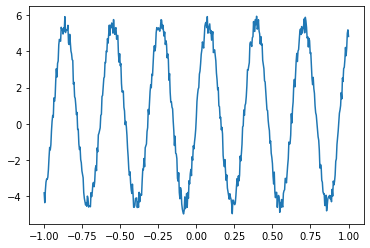

In [6]:
#Controle dos equipamentos mas sem a medida de fato
PSG.freq.set(20)
PSG.amp.set(5)
plt.plot(osc.t_axis(),osc.wavesample())

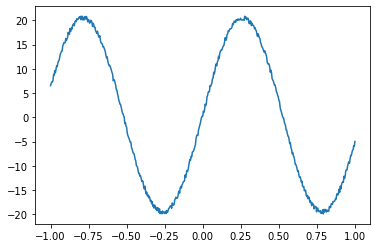

In [7]:
PSG.amp.set(20)
PSG.freq.set(6)
plt.plot(osc.t_axis(),osc.wavesample())

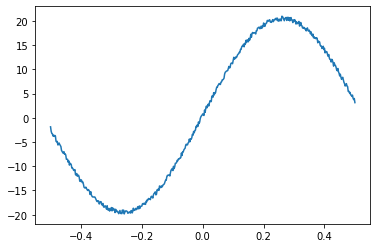

In [8]:
osc.t_stop.set(-0.5)
osc.t_start.set(0.5)
plt.plot(osc.t_axis(),osc.wavesample())

# Teste Medida 

In [9]:
# Station representa um conjunto de instrumentos
station = Station()
station.snapshot()

{'instruments': {},
 'parameters': {},
 'components': {},
 'config': None,
 'default_measurement': []}

In [10]:
station.add_component(osc)

'oscilloscope'

In [11]:
# Criar um database
initialise_or_create_database_at("~/teste.db")

In [12]:
#Definir um experimento
exp = load_or_create_experiment(experiment_name='osc_teste',
                                sample_name="osc teste 1")

In [13]:
# Medida de fato
meas = Measurement(exp=exp, station=station)
meas.register_parameter(osc.wavesample)

with meas.run() as datasaver:
    datasaver.add_result((osc.t_axis, osc.t_axis()),
                         (osc.wavesample, osc.wavesample()))
    dataset = datasaver.dataset

Starting experimental run with id: 7. 


([<matplotlib.axes._subplots.AxesSubplot at 0x1bd492ffc88>], [None])

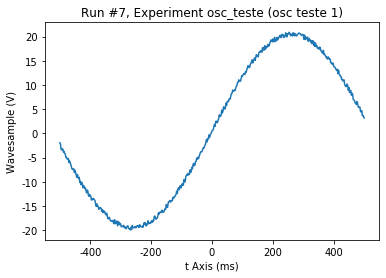

In [14]:
plot_dataset(dataset)

# Medida variando freq

In [15]:
exp = load_or_create_experiment(experiment_name='osc_teste variando freq',
                                sample_name="osc teste 1")

In [16]:
meas = Measurement(exp=exp, station=station)
meas.register_parameter(osc.wavesample)

freqs = np.linspace(1,4,10)
with meas.run() as datasaver:
    for freq in freqs:
        PSG.freq.set(freq)
        datasaver.add_result((osc.t_axis, osc.t_axis()),
                             (osc.wavesample, osc.wavesample()))
        dataset = datasaver.dataset

Starting experimental run with id: 8. 


([<matplotlib.axes._subplots.AxesSubplot at 0x1bd493c7888>], [None])

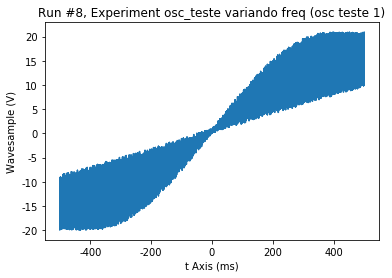

In [17]:
plot_dataset(dataset)